Visualize `data/W.csv` and `data/maps.pkl`.

In [10]:
import pickle
import numpy as np

with open("../data/maps.pkl", "rb") as in_f:
    maps = pickle.load(in_f)
W = np.loadtxt("../data/W.csv", delimiter=',')

# Visualizing Color Consistency

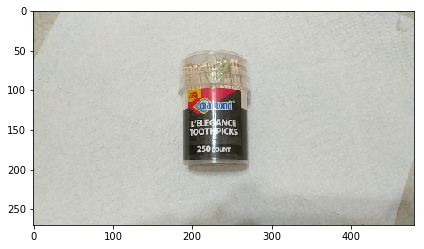

[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Lighter colors encode higher color consistency


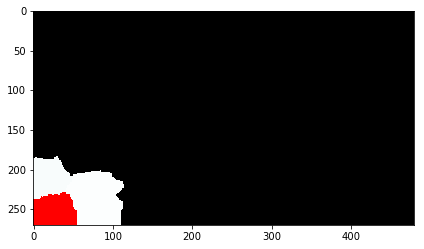

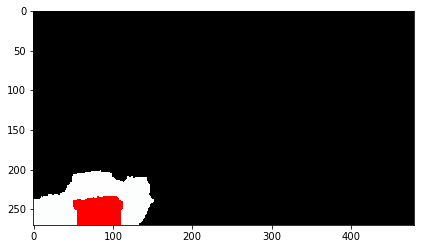

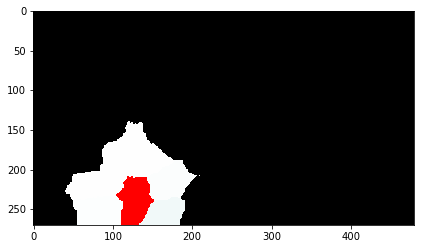

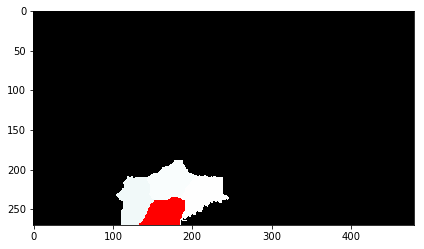

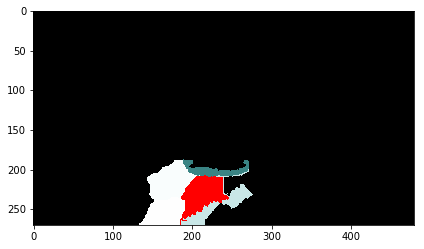

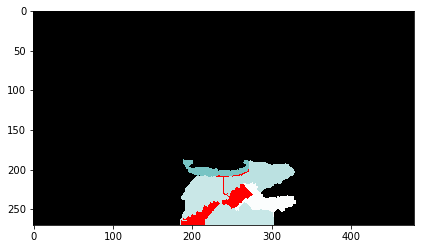

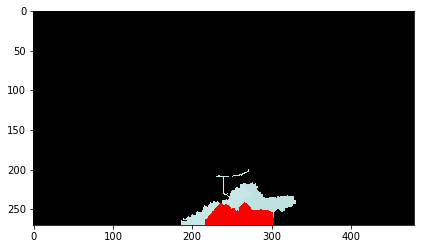

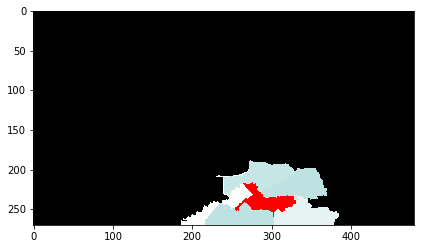

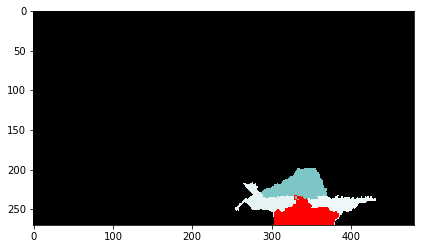

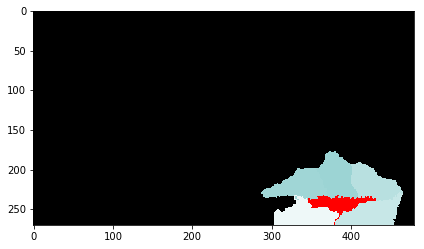

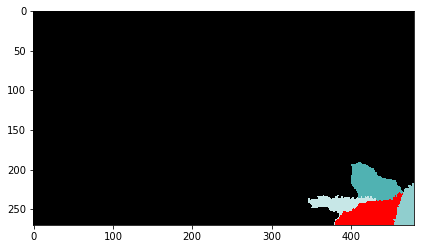

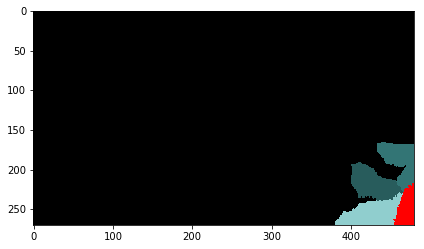

In [12]:
import imageio
import sys
from matplotlib import pyplot as plt
sys.path.append("../")
from helpers import *
import superpixels as sp
import epipolar as ep

spm = sp.SuperpixelsMaps(maps)

filename = '../data/toothpick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

frame_skip = 10
id1 = 0
img1 = get_smaller_image(vid, id1*frame_skip)
sp_map1 = maps[id1]

plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(img1)

if len(maps) > 1:
    id2 = 1
    img2 = get_smaller_image(vid, id2*frame_skip)
    sp_map2 = maps[id2]
    plt.subplot(222), plt.imshow(img2)

plt.show()

def get_superpixels_in_row(sp_map, y):
    sids = []
    for x in range(sp_map.shape[1]):
        sids.append(sp_map[y, x])
    sids = sorted(list(set(sids)))
    return sids

def highlight_superpixel(sp_map, msid, value=None, thresh=True):
    """ Set superpixel msid to a value while setting
        others to 0.
    """
    cp = sp_map.copy()
    cp[np.where(cp!=msid)] = -1
    if value is None:
        value = 255
    cp[np.where(cp==msid)] = value
    cp[np.where(cp==-1)] = 0
    cp = cp.astype(np.uint8)
    if thresh:
        cp = cv2.threshold(cp, 100, 255, cv2.THRESH_BINARY)[1]

    return cp

def highlight_superpixels_hsl(sp_map, msids, values=None, max_value=1.0,
                              max_intensity=255, min_intensity=50, h=90, s=100):
    """
    """
    h_channel = np.zeros((sp_map.shape[0], sp_map.shape[1]))
    s_channel = np.zeros((sp_map.shape[0], sp_map.shape[1]))
    l_channel = np.zeros((sp_map.shape[0], sp_map.shape[1]))
    for i, sid in enumerate(msids):
        if values is None:
            value = None
        else:
            value = min_intensity + (max_intensity - min_intensity) * (values[i]/max_value)
        l_highlight = highlight_superpixel(sp_map, sid, value=value, thresh=False)
        l_channel = np.sum((l_channel, l_highlight), axis=0)

        h_highlight = highlight_superpixel(sp_map, sid, value=h, thresh=False)
        h_channel = np.sum((h_channel, h_highlight), axis=0)

        s_highlight = highlight_superpixel(sp_map, sid, value=s, thresh=False)
        s_channel = np.sum((s_channel, s_highlight), axis=0)

    hls_img = np.stack((h_channel, l_channel, s_channel), axis=2).astype(np.uint8)
    rgb_img = cv2.cvtColor(hls_img, cv2.COLOR_HLS2RGB)
    return rgb_img

mtx = np.array([[ 633.14676506,    0.,            407.2286842 ],
                [   0.,            627.07243572,  281.21216339],
                [   0.,            0.,            1.        ]])

sids = get_superpixels_in_row(sp_map1, -1)
print(sids)
print("Lighter colors encode higher color consistency")

nodes = np.nonzero(W)
for sid in sids:
    adj_sids = nodes[1][np.where(nodes[0]==sid)]
    plt.figure(figsize=(15,15))
    
    # Create red tinted main superpixel id.
    r = highlight_superpixel(sp_map1, sid, value=255)
    g = np.zeros((sp_map1.shape[0], sp_map1.shape[1]))
    b = np.zeros((sp_map1.shape[0], sp_map1.shape[1]))

    # Adjacent superpixels in the same image.
    v_adj_sids = [sid] # valid adj_sids
    c_scores = [1.0] # Color consistency score
    for adj_sid in adj_sids:
        map_id, msid = spm.sid2msid(adj_sid)
        if map_id == id1:
            v_adj_sids.append(msid)
            c_scores.append(W[sid, adj_sid])
    himg = highlight_superpixels_hsl(sp_map1, v_adj_sids, values=c_scores)
    
    # Combine main superpixel image with the image above.
    himg[np.where(r==255)] = [255, 0, 0]
    plt.subplot(221), plt.imshow(himg)

    if len(maps) > 1:
        # Adjacent superpixels in the neighboring image.
        v_adj_sids = [] # valid adj_sids
        c_scores = [] # Color consistency score
        for adj_sid in adj_sids:
            map_id, msid = spm.sid2msid(adj_sid)
            if map_id == id2:
                v_adj_sids.append(msid)
                c_scores.append(W[sid, adj_sid])
        himg = highlight_superpixels_hsl(sp_map2, v_adj_sids, values=c_scores)

        plt.subplot(222), plt.imshow(himg)
    plt.show()